In [58]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pysyncon import Dataprep, Synth, AugSynth
from pysyncon.utils import PlaceboTest

In [59]:
# All states:
states = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]
# States belonging to RGGI. Exclude VA here; it was only in RGGI for a short time
# Connecticut, Delaware, Maine, Maryland, Massachusetts, New Hampshire, New Jersey, New York, Pennsylvania, Rhode Island, and Vermont 
rggi_states = ["CT", "DE", "ME", "MD", "MA", "NH", "NJ", "NY", "PA", "RI", "VT"]
# States with cap-and-trade programs as well as AK and HI, which are of course outside the continental US.
other_states = ["CA", "AK", "HI"]
# States not belonging to RGGI or other cap-and-trade programs.
# WA will be included here because its cap-and-trade program was not around until after 2020.
control_states = list(set(states) - set(rggi_states) - set(other_states))

In [60]:
# Read in the dataframe

df = pd.read_csv(os.path.join("..","..","..","SharedData", "total_state_data.csv"))
df.date = pd.to_datetime(df.date)
df = df[(df.date.dt.year>=1990)&(df.date.dt.year<2020)]

In [61]:
df.columns

Index(['state', 'state_sq_ft', 'year', 'month', 'date', 'monthly_population',
       'yearly_population', 'monthly_pop_density', 'yearly_pop_density',
       'monthly_emissions', 'monthly_emissions_sma', 'prcp', 'snow', 'tavg',
       'gdp_rel_2017', 'gdp_rel_2017_interp', 'yearly_gdp_rel_2017',
       'monthly_energy_prod', 'yearly_energy_prod', 'monthly_energy_use',
       'yearly_energy_use', 'monthly_energy_flow', 'yearly_energy_flow',
       'monthly_num_plants', 'yearly_num_plants', 'monthly_energy_total',
       'yearly_energy_total', 'monthly_energy_renew', 'yearly_energy_renew',
       'monthly_renew_pct', 'yearly_renew_pct', 'monthly_energy_fossil',
       'yearly_energy_fossil', 'monthly_fossil_pct', 'yearly_fossil_pct'],
      dtype='object')

In [62]:
# set number of months to skip at a time when training monthly model.
# month_jumps = 1 means consider all monthly data; month_jumps = 12 means consider one month per year
month_jumps = 1

# Get outcome
df['co2_per_capita'] = df['monthly_emissions'] / df['monthly_population']

# Get special predictors
df['gdp_per_capita'] = df['gdp_rel_2017_interp'] / df['monthly_population']
df['eprod_per_capita'] = df['monthly_energy_prod'] / df['monthly_population']
df['eflow_per_capita'] = df['monthly_energy_flow'] / df['monthly_population']

# Set up ranges
UL = 2009
LL_TIME = 1997      # Time range over which to perform fit

features = ['gdp_rel_2017_interp', 'monthly_energy_use', 'monthly_pop_density', 'monthly_emissions_sma','co2_per_capita']

# these are the time values where CO2 per capita is fit
preintervention_time_range = df.date[(df.date.dt.year>=LL_TIME)&(df.date.dt.year<UL)][::month_jumps]

# these are the time values where our features are fit (subset of preintervention_time_range)
preintervention_feature_range = df.date[(df.date >= '1997-01-01') & (df.date<'2009-01-01')][::month_jumps]
preintervention_weather_range = df.date[(df.date >= '1990-01-01') & (df.date<'2009-01-01')][::month_jumps]
preintervention_gdp_range = df.date[(df.date >= '1997-12-01') & (df.date<'2009-01-01')][::month_jumps]
preintervention_per_capita_range = df.date[(df.date >= '1990-06-01') & (df.date<'2009-01-01')][::month_jumps]
preintervention_energy_range = df.date[(df.date >= '1990-12-01') & (df.date<'2009-01-01')][::month_jumps]
preintervention_ma_range = df.date[(df.date >= '1991-05-01') & (df.date<'2009-01-01')][::month_jumps]

# these are the dates used for our monthly_emissions graph
years = pd.date_range(start='1990-06-01', end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()[::month_jumps]

# these are the dates used for our monthly_emissions SMA graph
years_sma = pd.date_range(start='1991-05-01', end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()[::month_jumps]

In [63]:
# we leave off RGGI states, states with no CO2 data (AK, HI), as well as states with some type of emissions program (CA, WA)

rggi_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'RI', 'VT', 'VA']

non_rggi_controls_identifier= [
    "AL", 
    "AZ", "AR", 
    "CO", 
    "FL", 
    "GA",
    "ID", "IL", "IN", "IA", "KS", "KY", "LA", 
    "MI", "MN", "MS", "MO", "MT", "NE", "NV", 
    "NM", "NC", "ND", "OH", "OK", 
    "OR", 
    "PA", 
    "SC", "SD", "TN", 
    "TX", 
    "UT", 
    "WV", "WI", "WY"
    ]

We first fit a synthetic control model on CO2 per capita, using the state of Delaware as our unit of interest. 

In [64]:
dataprep = Dataprep(
    foo=df,
    predictors=['monthly_num_plants', 'co2_per_capita'],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('monthly_energy_use', preintervention_energy_range, "mean"),
        ('eflow_per_capita', preintervention_energy_range, "mean"),
        ('gdp_rel_2017_interp', preintervention_gdp_range, "mean"),
        ('monthly_pop_density', preintervention_per_capita_range, "mean"),
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_time_range
    )

In [65]:
print(dataprep)

Dataprep
Treated unit: DE
Dependent variable: co2_per_capita
Control units: AL, AZ, AR, CO, FL, GA, ID, IL, IN, IA, KS, KY, LA, MI, MN, MS, MO, MT, NE, NV, NM, NC, ND, OH, OK, OR, PA, SC, SD, TN, TX, UT, WV, WI, WY
Time range in data: 1990-01-01 00:00:00 - 2019-12-01 00:00:00
Time range for loss minimization: 4032    1997-01-01
4033    1997-02-01
4034    1997-03-01
4035    1997-04-01
4036    1997-05-01
           ...    
10939   2008-08-01
10940   2008-09-01
10941   2008-10-01
10942   2008-11-01
10943   2008-12-01
Name: date, Length: 6912, dtype: datetime64[ns]
Time range for predictors: 4032    1997-01-01
4033    1997-02-01
4034    1997-03-01
4035    1997-04-01
4036    1997-05-01
           ...    
10939   2008-08-01
10940   2008-09-01
10941   2008-10-01
10942   2008-11-01
10943   2008-12-01
Name: date, Length: 6912, dtype: datetime64[ns]
Predictors: monthly_num_plants, co2_per_capita
Special predictors:
    `monthly_energy_use` over `11      1990-12-01
23      1990-12-01
35      1990

In [66]:
synth = Synth()
synth.fit(dataprep=dataprep)
print(synth.weights(threshold=.01))
print(synth.loss_V)


ID    0.299
IA    0.046
NE    0.133
NV    0.135
ND    0.037
SD    0.350
Name: weights, dtype: float64
0.02878026431642665


In [67]:
treatment_dates = []
for year in years:
    if year.startswith('2009'):
        treatment_dates.append(year)

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


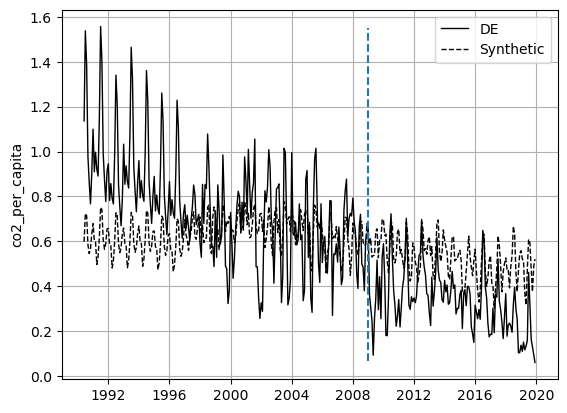

In [68]:
# Convert treatment_dates[0] to a datetime object
treatment_time = pd.to_datetime(treatment_dates[0])
synth.path_plot(time_period=years, treatment_time=treatment_time)

In [69]:
synth.summary()

,V,treated,synthetic,sample mean
monthly_num_plants,0.008,7.840,5.856,21.660
co2_per_capita,0.552,0.656,0.652,1.375
special.1.monthly_energy_use,0.091,23296.069,36257.530,163357.042
special.2.eflow_per_capita,0.264,-0.030,-0.020,0.031
special.3.gdp_rel_2017_interp,0.084,5327.389,5365.302,21495.546
special.4.monthly_pop_density,0.000,0.003,0.075,0.034


In [36]:
synth.loss_V

0.03487415110482785

In [70]:
placebo_test = PlaceboTest()
placebo_test.fit(
    dataprep=dataprep,
    scm=synth
)

(1/35) Completed placebo test for FL.
(2/35) Completed placebo test for ID.
(3/35) Completed placebo test for IL.
(4/35) Completed placebo test for KS.
(5/35) Completed placebo test for MN.
(6/35) Completed placebo test for MS.
(7/35) Completed placebo test for AR.
(8/35) Completed placebo test for MT.
(9/35) Completed placebo test for LA.
(10/35) Completed placebo test for MI.
(11/35) Completed placebo test for CO.
(12/35) Completed placebo test for IA.
(13/35) Completed placebo test for GA.
(14/35) Completed placebo test for KY.
(15/35) Completed placebo test for MO.
(16/35) Completed placebo test for AZ.
(17/35) Completed placebo test for TX.
(18/35) Completed placebo test for AL.
(19/35) Completed placebo test for OK.
(20/35) Completed placebo test for NM.
(21/35) Completed placebo test for WY.
(22/35) Completed placebo test for ND.
(23/35) Completed placebo test for NE.
(24/35) Completed placebo test for IN.
(25/35) Completed placebo test for SC.
(26/35) Completed placebo test for

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/pysyncon/utils.py:306: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  placebo_gaps = gaps[gaps.index.isin(time_period)][keep]


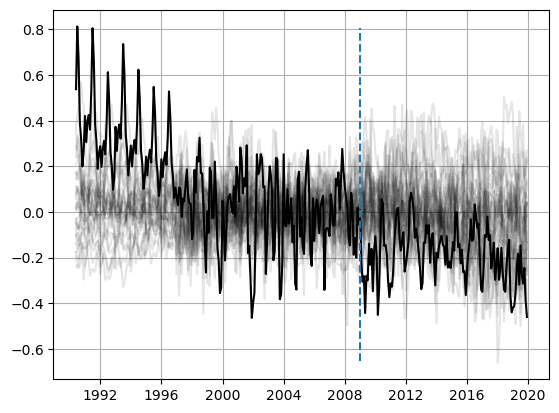

In [71]:
placebo_test.gaps_plot(time_period=years, treatment_time=treatment_time, mspe_threshold=1)

In [72]:
placebo_test.pvalue(treatment_time=treatment_time)

0.8611111111111112

We now run a placebo test on a synthetic control model on Delaware joining the RGGI using a 12-month moving average of emissions as our outcome variable. 

In [73]:
df['co2_emissions_per_capita_sma'] = (df['monthly_emissions'] / df['monthly_population']).rolling(window=12).mean()

In [74]:
df['co2_emissions_per_capita_sma'].isna().sum()

np.int64(580)

In [87]:
features_ma = ['co2_emissions_per_capita_sma', 'gdp_rel_2017_interp', 'monthly_energy_use', 'monthly_pop_density','monthly_num_plants']

In [81]:
dataprep_ma = Dataprep(
    foo=df,
    predictors=['monthly_num_plants', 'co2_emissions_per_capita_sma'],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('monthly_energy_use', preintervention_energy_range, "mean"),
        ('eflow_per_capita', preintervention_energy_range, "mean"),
        ('gdp_rel_2017_interp', preintervention_gdp_range, "mean"),
        ('monthly_pop_density', preintervention_per_capita_range, "mean"),
        ],
    dependent="co2_emissions_per_capita_sma",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_ma_range
    )

In [82]:
synth_ma = Synth()
synth_ma.fit(dataprep=dataprep_ma)
print(synth_ma.weights(threshold=.01))
print(synth_ma.loss_V)

SC    0.617
TN    0.383
Name: weights, dtype: float64
0.01851200826204658


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


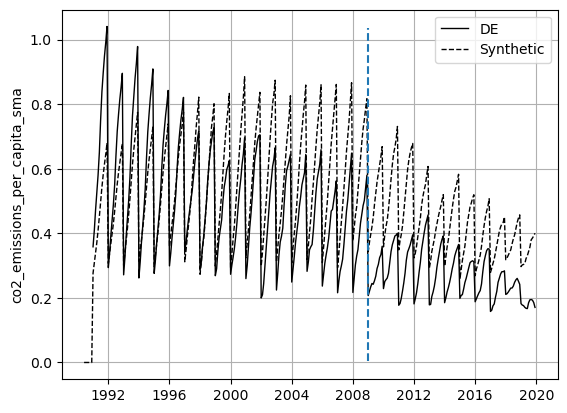

In [83]:
synth_ma.path_plot(time_period=years, treatment_time=treatment_time)

In [84]:
placebo_test_ma = PlaceboTest()
placebo_test_ma.fit(
    dataprep=dataprep_ma,
    scm=synth_ma
)

(1/35) Completed placebo test for FL.
(2/35) Completed placebo test for ID.
(3/35) Completed placebo test for AL.
(4/35) Completed placebo test for AR.
(5/35) Completed placebo test for CO.
(6/35) Completed placebo test for GA.
(7/35) Completed placebo test for MS.
(8/35) Completed placebo test for IL.
(9/35) Completed placebo test for MN.
(10/35) Completed placebo test for IN.
(11/35) Completed placebo test for IA.
(12/35) Completed placebo test for MT.
(13/35) Completed placebo test for KY.
(14/35) Completed placebo test for LA.
(15/35) Completed placebo test for KS.
(16/35) Completed placebo test for MI.
(17/35) Completed placebo test for NE.
(18/35) Completed placebo test for TX.
(19/35) Completed placebo test for SD.
(20/35) Completed placebo test for ND.
(21/35) Completed placebo test for WY.
(22/35) Completed placebo test for OK.
(23/35) Completed placebo test for NM.
(24/35) Completed placebo test for PA.
(25/35) Completed placebo test for AZ.
(26/35) Completed placebo test for

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/pysyncon/utils.py:306: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  placebo_gaps = gaps[gaps.index.isin(time_period)][keep]


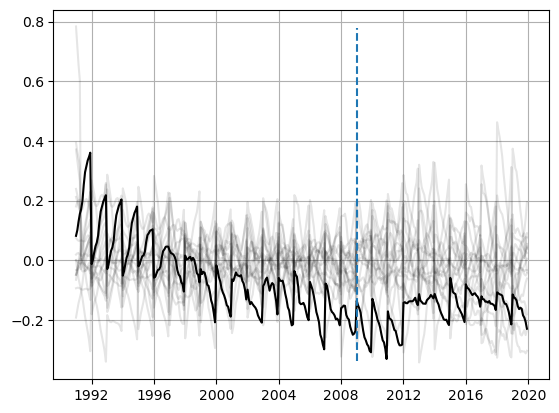

In [88]:
placebo_test_ma.gaps_plot(time_period=years, treatment_time=treatment_time, mspe_threshold=1)

In [89]:
placebo_test_ma.pvalue(treatment_time=treatment_time)

0.25